In [3]:
!unzip data.zip 

Archive:  data.zip
   creating: data/beach/
  inflating: data/beach/beach01.jpg  
  inflating: data/beach/beach02.jpg  
  inflating: data/beach/beach03.jpg  
  inflating: data/beach/beach04.jpg  
   creating: data/beach_with_tree/
  inflating: data/beach_with_tree/tree01.jpg  
  inflating: data/beach_with_tree/tree02.jpg  
  inflating: data/beach_with_tree/tree03.jpg  
  inflating: data/beach_with_tree/tree04.jpg  
  inflating: data/beach_with_tree/tree05.jpg  
   creating: data/cat/
  inflating: data/cat/cat01.jpg      
  inflating: data/cat/cat02.jpg      
   creating: data/cat/orange/
  inflating: data/cat/orange/cat01.jpg  
  inflating: data/cat/orange/cat02.jpg  
  inflating: data/cat/orange/cat03.jpg  
  inflating: data/cat/orange/cat04.jpg  
  inflating: data/cat/orange/cat05.jpg  
  inflating: data/cat/orange/cat06.jpg  
  inflating: data/cat/orange/cat07.jpg  
  inflating: data/cat/orange/cat08.jpg  


In [4]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt 
import cv2 
import utils 

%matplotlib inline 

# Clustering 
Using clustering to identify a smaller set of points for prediction.  Turn the regression problem into a classification problem.  

## Data wrangling 

In [6]:
import glob 

filenames = glob.glob('data/beach_with_tree/*.jpg')
filenames

['data/beach_with_tree/tree05.jpg',
 'data/beach_with_tree/tree01.jpg',
 'data/beach_with_tree/tree04.jpg',
 'data/beach_with_tree/tree02.jpg',
 'data/beach_with_tree/tree03.jpg']

`imgs` is a list of all utils.Image objects from the above list 

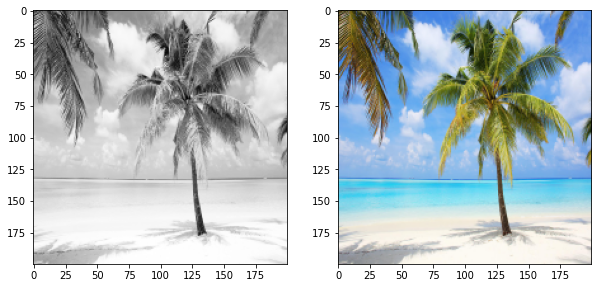

In [7]:
dim = 200
padding = 55

imgs = []

for idx, file in enumerate(filenames): 
    imgs.append(utils.Image(filenames[idx], resize=dim, padding=padding))

    
fig, axes = plt.subplots(1, 2, figsize=(10, 20))
axes[0].imshow(-imgs[0].gray_nopadding, cmap=plt.get_cmap('Greys'))
axes[1].imshow(cv2.cvtColor(imgs[0].data_nopadding, cv2.COLOR_BGR2RGB))

## Identify cluster using kmeans 

In [8]:
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

In [9]:
img = imgs[0].data_nopadding/255
n_colors = 64


w, h, d = tuple(img.data.shape)

image_array = np.reshape(img, (w * h, d))
image_array_sample = shuffle(image_array, random_state=0)

kmeans = KMeans(n_clusters=n_colors, random_state = 0, verbose=0).fit(image_array_sample)

In [10]:
clusters  = kmeans.cluster_centers_

clusters = np.array(clusters)

indeces_of_nearest_cluster = kmeans.predict(image_array)
indeces_of_nearest_cluster = np.reshape(indeces_of_nearest_cluster, (w, h))

In [11]:
new_image  = np.zeros(shape = (w,h,d))
for row in range(w):
    for col in range(h):
        new_image[row, col, 0] = clusters[indeces_of_nearest_cluster[row, col], 0]
        new_image[row, col, 1] = clusters[indeces_of_nearest_cluster[row, col], 1]
        new_image[row, col, 2] = clusters[indeces_of_nearest_cluster[row, col], 2]
        
        
new_image = (new_image*255).astype('uint8')

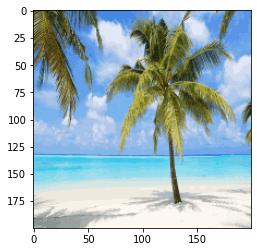

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

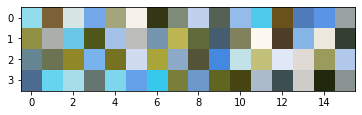

In [13]:
colors = (clusters*255).reshape(4, -1, 3).astype('uint8')
plt.imshow(cv2.cvtColor(colors, cv2.COLOR_BGR2RGB))

## Converting RGB to one-hot encoding 
Do this for all images in `imgs` list 

In [123]:
y = [] 

for img in imgs: 

    img = img.data_nopadding/255

    w, h, d = tuple(img.data.shape)

    image_array = np.reshape(img, (w * h, d))
    
    indeces_of_nearest_cluster = kmeans.predict(image_array)
    indeces_of_nearest_cluster = np.reshape(indeces_of_nearest_cluster, (w, h))
    
    utils.get_onehotencoding_vectors(indeces_of_nearest_cluster, n_colors, y) 
       

y = np.array(y)
w_size = 7 
X, _ = utils.imgs_to_dataset(filenames, resize=dim, padding=padding, window_size=w_size)

In [124]:
X.shape, y.shape

((200000, 49), (200000, 64))

In [125]:
X = utils.normalize(X)

train, test split 

In [126]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2019)

In [127]:
X_train.shape, y_train.shape

((180000, 49), (180000, 64))

## Model building 

In [128]:
from tensorflow.keras.layers import Dense, InputLayer

In [ ]:
model = tf.keras.Sequential([ 
    Dense(100, input_shape=(w_size**2, ), activation='sigmoid'), 
    Dense(50, activation='relu'), 
    Dense(n_colors, activation='softmax')
])


In [141]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy')  

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 100)               5000      
_________________________________________________________________
dense_26 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_27 (Dense)             (None, 64)                3264      
Total params: 13,314
Trainable params: 13,314
Non-trainable params: 0
_________________________________________________________________


In [142]:
EPOCHS = 50

history = model.fit(X_train, 
                    y_train, 
                    epochs=EPOCHS, 
                    verbose=2)

Epoch 1/50
5625/5625 - 7s - loss: 1.6296
Epoch 2/50
5625/5625 - 7s - loss: 1.6116
Epoch 3/50
5625/5625 - 7s - loss: 1.6069
Epoch 4/50
5625/5625 - 7s - loss: 1.6038
Epoch 5/50
5625/5625 - 7s - loss: 1.6018
Epoch 6/50
5625/5625 - 7s - loss: 1.6000
Epoch 7/50
5625/5625 - 7s - loss: 1.5986
Epoch 8/50
5625/5625 - 7s - loss: 1.5975
Epoch 9/50
5625/5625 - 7s - loss: 1.5965
Epoch 10/50
5625/5625 - 7s - loss: 1.5957
Epoch 11/50
5625/5625 - 7s - loss: 1.5949
Epoch 12/50
5625/5625 - 7s - loss: 1.5941
Epoch 13/50
5625/5625 - 7s - loss: 1.5936
Epoch 14/50
5625/5625 - 7s - loss: 1.5928
Epoch 15/50
5625/5625 - 7s - loss: 1.5923
Epoch 16/50
5625/5625 - 7s - loss: 1.5917
Epoch 17/50
5625/5625 - 7s - loss: 1.5914
Epoch 18/50
5625/5625 - 7s - loss: 1.5908
Epoch 19/50
5625/5625 - 7s - loss: 1.5904
Epoch 20/50
5625/5625 - 7s - loss: 1.5898
Epoch 21/50
5625/5625 - 7s - loss: 1.5896
Epoch 22/50
5625/5625 - 7s - loss: 1.5893
Epoch 23/50
5625/5625 - 7s - loss: 1.5888
Epoch 24/50
5625/5625 - 7s - loss: 1.5885
E

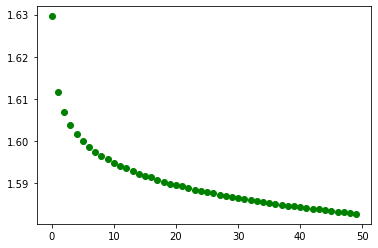

In [143]:
l = history.history['loss']

x_ = np.arange(len(l))
plt.scatter(x_, l, c='g') 

## Test on image 

In [1]:
img = imgs[1]
# img = utils.Image('data/beach/beach01.jpg', resize=dim, padding=50) 

X_test = []

for i in range(dim): 
    for j in range(dim): 

        i_ = i + img.padding
        j_ = j + img.padding

        grays, b, g, r = img.get_dataset_for_pixel(i_, j_, window_size=w_size)
        X_test.append(grays)
X_test = np.array(X_test)
X_test = utils.normalize(X_test)
y_model = model.predict(X_test)

NameError: ignored

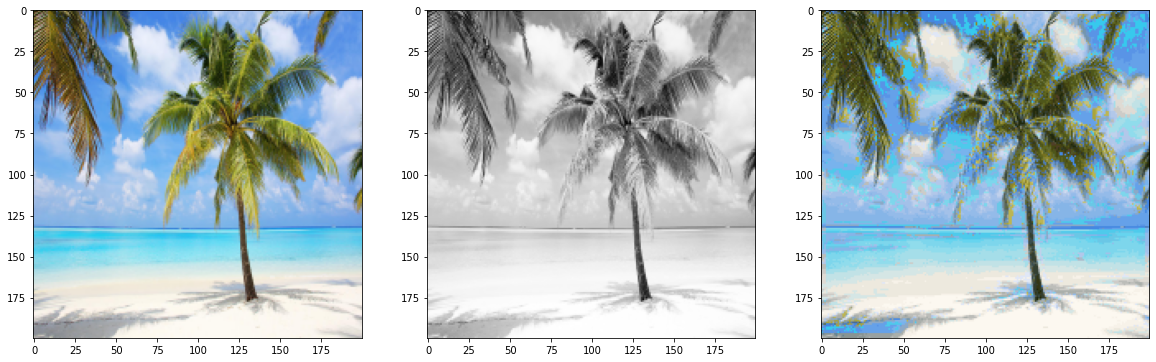

In [145]:
new_image  = np.zeros(shape = (y_model.shape[0], 3))

for i in range(y_model.shape[0]):              
    new_image[i] = clusters[np.argmax(y_model[i, :])]
        
new_image = (new_image*255).astype('uint8')
new_image = new_image.reshape(dim, dim, 3)

fig, ax = plt.subplots(1, 3, figsize=(20, 10))

ax[0].imshow(cv2.cvtColor(img.data_nopadding, cv2.COLOR_BGR2RGB))
ax[1].imshow(-img.gray_nopadding, cmap=plt.get_cmap('Greys'))
ax[2].imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))